In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import sys
import networkx as nx
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, r2_score
import dgl
import dgl.data
import torch
import torch.nn as nn
import torch.nn.functional as F
from dgl.dataloading import GraphDataLoader
from dgl.data import DGLDataset
import urllib
from dgl.dataloading import GraphDataLoader
from torch.utils.data.sampler import SubsetRandomSampler
from dgl.nn import GraphConv
import warnings
from torch.utils.data import DataLoader
from datetime import timedelta
import network_build
from tqdm import tqdm

/home/antoine/.local/lib/python3.6/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Graph construction

In [2]:
date = "2022-06-01"
network_metrics = pd.read_csv("./../Database/network_metrics_%s.csv" % date, index_col=0)
SP = pd.read_csv("./../Database/SP_60_%s.csv" % date, index_col=0)

# Use of chunk size because a problem of memory

chunk_size = 10000 
chunks_iterator = pd.read_csv("./../Database/order_clean_260.csv",index_col=0, chunksize=chunk_size)
chunks=[]
for chunk in chunks_iterator:
    chunks.append(chunk)
order = pd.concat(chunks)
order["call_time"] = pd.to_datetime(order["call_time"])
order["end_time"] = pd.to_datetime(order["end_time"])
start_time = pd.to_datetime(date + " 06:00:00 AM")
end_time = pd.to_datetime(date + " 12:00:00 PM")
order_one_day = order[(order["call_time"] >= start_time) & (order["call_time"] < end_time)]

SP.columns = ["SP"]
SP = SP.reset_index(drop=True)
order_one_day = order_one_day.sort_values(by="call_time").reset_index(drop=True)
network_metrics = network_metrics.reset_index(drop=True)

# the length of the three dataframes should be the same
assert len(order_one_day) == len(network_metrics) == len(SP)

# the index of the three dataframes should be the same
assert order_one_day.index.equals(network_metrics.index) 
assert SP.index.equals(network_metrics.index)


df = pd.concat([order_one_day, network_metrics, SP], axis=1).dropna()

In [3]:
t_opt = timedelta(days=0,hours = 0, minutes=20); t_lock = timedelta(days=0,hours = 0, minutes=10) ; t0  = pd.to_datetime("2022-06-01 06:00:00 AM")
t= t0
i=0
area = np.load("./../Database/NY_area.npy")
nodes = pd.DataFrame(columns=['nodes','graph_id'])
edges = pd.DataFrame(columns=['src','dst','graph_id'])
progress_bar = tqdm(total=30, desc="Progression")
while t+t_opt <= pd.to_datetime("2022-06-01 11:00:00 AM"):

    # the start time and end time are [t, t+t_opt)]
    order_start_time = t
    order_end_time = t+t_opt

    # this is very important to make sure >= in call time and < in end time
    order_pick = order_one_day[(order_one_day["call_time"] >= order_start_time) & (order_one_day["call_time"] < order_end_time)]
    order_pick = order_pick[["sid", "call_time", "eid", "end_time"]]

    net = network_build.ConstructNetwork(order_pick.values, area, void = 10)
    G_order = net.build_network(network_type="order")
    '''G_order.add_node('sink')
    for node in G_order.nodes():
        if node != 'sink':
            G_order.add_edge(node, 'sink', weight=0)'''
    current_nodes = pd.DataFrame(G_order.nodes,columns=["nodes"])
    current_nodes["graph_id"] = np.full(len(G_order.nodes),i,dtype=int)

    current_edges = pd.DataFrame(G_order.edges,columns = ['src','dst'])
    current_edges["graph_id"] = np.full(len(G_order.edges),i,dtype=int)

    nodes = pd.concat([nodes,current_nodes],ignore_index=True)
    edges = pd.concat([edges,current_edges],ignore_index=True)
    progress_bar.update(1)
    i+=1
    t+=t_lock
progress_bar.close()

Progression:  97%|█████████▋| 29/30 [05:07<00:10, 10.59s/it]


In [4]:
nodes.to_csv('nodes_t_opt_20_t_lock_10.csv')
edges.to_csv('edges_t_opt_20_t_lock_10.csv')

# Class and model

In [34]:
class My_Data(DGLDataset):
    def __init__(self, t_opt,t_lock,date):
        self.t_opt = t_opt
        self.t_lock = t_lock
        self.date = date
        super().__init__(name="synthetic")
        
    def process(self):

        self.t0 = pd.to_datetime(self.date + " 06:00:00 AM")
        t = self.t0

        network_metrics = pd.read_csv("./../Database/network_metrics_%s.csv" % self.date, index_col=0)
        SP = pd.read_csv("./../Database/SP_60_%s.csv" % self.date, index_col=0)

        # Use of chunk size because of a problem of memory

        chunk_size = 10000 
        chunks_iterator = pd.read_csv("./../Database/order_clean_260.csv",index_col=0, chunksize=chunk_size)
        chunks=[]
        for chunk in chunks_iterator:
            chunks.append(chunk)
        order = pd.concat(chunks)
        order["call_time"] = pd.to_datetime(order["call_time"])
        order["end_time"] = pd.to_datetime(order["end_time"])
        start_time = pd.to_datetime(self.date + " 06:00:00 AM")
        end_time = pd.to_datetime(self.date + " 12:00:00 PM")
        order_one_day = order[(order["call_time"] >= start_time) & (order["call_time"] < end_time)]

        SP.columns = ["SP"]
        SP = SP.reset_index(drop=True)
        order_one_day = order_one_day.sort_values(by="call_time").reset_index(drop=True)
        network_metrics = network_metrics.reset_index(drop=True)


        '''df = pd.concat([order_one_day, network_metrics, SP], axis=1).dropna()'''
        df = pd.concat([order_one_day, SP], axis=1).dropna()
        
        nodes = pd.read_csv('./nodes_t_opt_%s_t_lock_%s.csv' % (str(int(self.t_opt.seconds/60)),str(int(self.t_lock.seconds/60))),index_col = 0)
        edges = pd.read_csv('./edges_t_opt_%s_t_lock_%s.csv' % (str(int(self.t_opt.seconds/60)),str(int(self.t_lock.seconds/60))), index_col = 0)

        self.graphs = []
        i=0
        while t + self.t_opt <= pd.to_datetime("%s 11:00:00 AM" % self.date):
            cur_nodes = nodes[nodes["graph_id"]==i]
            num_nodes = len(cur_nodes)
            cur_edges = edges[edges["graph_id"]==i]
            # i rename every nodes as 'i' instead of 'ti' and replace sink by '-1'
            cur_edges = cur_edges.replace("sink","t-1")   
            cur_edges["src"]= cur_edges["src"].str.slice(1).astype(int)
            cur_edges["dst"]= cur_edges["dst"].str.slice(1).astype(int)

            src = torch.from_numpy(cur_edges["src"].to_numpy())
            dst = torch.from_numpy(cur_edges["dst"].to_numpy())

            nodes_feature = df[(df['call_time']>=t )& (df['call_time']<t+self.t_opt)]

            '''sink = {'sid' : 0,	'call_time': t+self.t_opt,	'eid':0,	'end_time' : t + self.t_opt,	'delta_min' : 0,	'degree' : 0,	'in_degree' : 0,	'out_degree': 0, 'betweenness_centrality' :0,	'closeness_centrality': 0,	'katz_centrality' : 0, 'SP' :0}'''
            '''sink = {'sid' : 0,	'call_time': t+self.t_opt,	'eid':0,	'end_time' : t + self.t_opt,	'delta_min' : 0, 'SP' :0}
            sink_df = pd.DataFrame([sink])'''
            '''nodes_feature = pd.concat([nodes_feature, sink_df], ignore_index=True)'''
            labels = nodes_feature.pop('SP')

            # change date time into seconds between 6 am and the current time

            call_list = nodes_feature["call_time"]
            call_num = [int(ts.timestamp()-(self.t0).timestamp()) for ts in call_list]

            nodes_feature[ "call_time"] = call_num

            end_list = nodes_feature["end_time"]
            end_num = [int(ts.timestamp()-(self.t0).timestamp()) for ts in end_list]

            nodes_feature["end_time"] = end_num

            nodes_feature = torch.from_numpy(nodes_feature.to_numpy())
            labels = torch.from_numpy(labels.to_numpy())

            self.feature_dim = 5

            g = dgl.graph((src, dst), num_nodes=num_nodes)
            g.ndata["feat"] = nodes_feature
            g.ndata["labels"] = labels
            g.ndata["graph_id"] = torch.from_numpy(np.zeros(nodes_feature.shape[0])+i)

            self.graphs.append(g)
            i+=1
            t+=self.t_lock
    def __getitem__(self, i):
        return self.graphs[i],self.graphs[i].ndata["labels"]
    def __len__(self):
        return len(self.graphs)

In [35]:

class EarlyStopping:
    def __init__(self, tolerance=5, min_delta=0):

        self.tolerance = tolerance
        self.min_delta = min_delta
        self.counter = 0
        self.early_stop = False

    def __call__(self, train_loss, validation_loss):
        if (validation_loss - train_loss) > self.min_delta:
            self.counter +=1
            if self.counter >= self.tolerance:  
                self.early_stop = True

In [36]:
class GCN_model(nn.Module):
    def __init__(self, in_feats, hidden_size, num_classes):
        super(GCN_model, self).__init__()
        self.conv1 = GraphConv(in_feats, hidden_size,allow_zero_in_degree=True)
        self.conv2 = GraphConv(hidden_size, num_classes,allow_zero_in_degree=True)
        self.dropout = nn.Dropout(0.2)

    def forward(self, g, features):
        h = self.conv1(g, features)
        h = F.relu(h)
        h = self.conv2(g, h)
        h= F.relu(h)
        h=self.dropout(h)
        g.ndata['h']=h
        
        return F.log_softmax(h, dim=1)


In [37]:
dataset = My_Data(t_opt=timedelta(minutes=20),t_lock=timedelta(minutes=10),date = "2022-06-01")

/home/antoine/.local/lib/python3.6/site-packages/ipykernel_launcher.py:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/antoine/.local/lib/python3.6/site-packages/ipykernel_launcher.py:74: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/antoine/.local/lib/python3.6/site-packages/ipykernel_launcher.py:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pand

# First results !!! ( Testimony)

In [40]:
class GCN_model(nn.Module):
    def __init__(self, in_feats, hidden_size, num_classes):
        super(GCN_model, self).__init__()
        self.conv1 = GraphConv(in_feats, hidden_size,allow_zero_in_degree=True)
        self.conv2 = GraphConv(hidden_size, num_classes,allow_zero_in_degree=True)
        self.dropout = nn.Dropout(0.2)

    def forward(self, g, features):
        h = self.conv1(g, features)
        h = F.relu(h)
        h = self.conv2(g, h)
        h= F.relu(h)
        h=self.dropout(h)
        g.ndata['h']=h
        
        return F.log_softmax(h, dim=1)

0: 25.094386784926705: 27.31375503540039
1: 14.913792962613313: 17.548239707946777
2: 11.292080775551174: 12.879317283630371
3: 8.707135780997898: 9.580990314483643
4: 6.160644624544227: 5.564045667648315
5: 3.5963290566983432: 2.8196603059768677
6: 2.858639333559119: 2.8169857263565063
7: 2.8303419507068135: 2.8146169185638428
8: 2.8172256635582964: 2.811201333999634
9: 2.8105012852212656: 2.8078943490982056


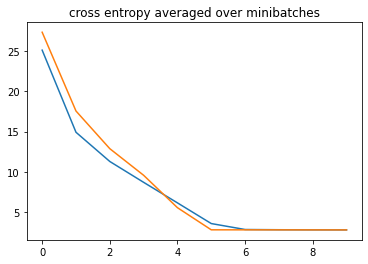

Test accuracy: 182.0


In [39]:
# I tryed differnet batch_size 
batch_size = 1
input_dim = 4
hidden_dim = 64
num_classes = 17
lr = 0.01
n_epoch = 10

node_feature_dim = dataset.feature_dim

num_examples = len(dataset)
num_train = int(num_examples * 0.8)
num_val = int(num_examples * 0.1)

t = torch.arange(num_train)
idx = torch.randperm(t.nelement())
t = t.view(-1)[idx].view(t.size())
train_sampler = SubsetRandomSampler(t)

t = torch.arange(num_train, num_train+num_val)
idx = torch.randperm(t.nelement())
t = t.view(-1)[idx].view(t.size())
val_sampler = SubsetRandomSampler(t)

t = torch.arange(num_train+num_val, num_examples)
idx = torch.randperm(t.nelement())
t = t.view(-1)[idx].view(t.size())
test_sampler = SubsetRandomSampler(t)

train_dataloader = GraphDataLoader(
    dataset, sampler=train_sampler,batch_size=batch_size, drop_last=False, shuffle=False,
)
val_dataloader = GraphDataLoader(
    dataset, sampler=val_sampler, batch_size=batch_size, drop_last=False, shuffle=False,
)
test_dataloader = GraphDataLoader(
    dataset, sampler=test_sampler, batch_size=batch_size, drop_last=False, shuffle=False,
)

model = GCN_model(node_feature_dim, hidden_dim, num_classes)
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

early_stopping = EarlyStopping(tolerance=5, min_delta=10)

epoch_losses = []; val_losses = []
for epoch in range(n_epoch):
    epoch_loss = 0
    for iter, (batched_graph, labels) in enumerate(train_dataloader):
        
        pred = model(batched_graph, batched_graph.ndata["feat"].float())
        
        loss = F.cross_entropy(pred, torch.squeeze(labels))
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        epoch_loss += loss.detach().item()
    epoch_loss /= (iter + 1)
    epoch_losses.append(epoch_loss)
    
    val_loss = 0
    with torch.no_grad():
        for iter, (batched_graph, labels) in enumerate(val_dataloader):
            pred = model(batched_graph, batched_graph.ndata["feat"].float())
            loss = F.cross_entropy(pred, torch.squeeze(labels))
            val_loss += loss.detach().item()
        val_loss /= (iter + 1)
    val_losses.append(val_loss)
    
    early_stopping(epoch_loss, val_loss)
    if early_stopping.early_stop:
        print("We are at epoch:", epoch)
        break
    print(str(epoch)+': '+str(epoch_loss)+': '+str(val_loss))

plt.title('cross entropy averaged over minibatches')
plt.plot(epoch_losses, label='Train')
plt.plot(val_losses, label='Test')
plt.show()

num_correct = 0
num_tests = 0

pred_batch = []; id_batch = []
for batched_graph, labels in test_dataloader:
    graphs = dgl.unbatch(batched_graph)

    for i in range(len(graphs)):
        id_batch += [int(graphs[i].ndata["graph_id"][0].numpy())]

    pred = model(batched_graph, batched_graph.ndata["feat"].float())
    num_correct += (pred.argmax(1) == labels).sum().item()
    pred_batch += list((pred.argmax(1)).numpy())
    
    num_tests += len(labels)


print("Test accuracy:", num_correct / num_tests)

Big problem of accuracy, not good calculation

# Improving enthropie

In [64]:
class GCN_model_2(nn.Module):
    def __init__(self, in_feats, hidden_size, num_classes):
        super(GCN_model_2, self).__init__()
        self.conv1 = GraphConv(in_feats, hidden_size, allow_zero_in_degree=True)
        self.conv2 = GraphConv(hidden_size, num_classes, allow_zero_in_degree=True)
        self.dropout = nn.Dropout(0.2)

    def forward(self, g, features):
        h = self.conv1(graph=g, feat=features)
        h = F.relu(h)
        h = self.conv2(graph=g, feat=h)
        h = F.relu(h)
        h = self.dropout(h)
        
        return h

0: 28.614674039508987: 2.811286687850952
1: 2.8606256091076396: 2.7827563285827637
2: 3.037905672322149: 2.7585089206695557
3: 2.739632160767265: 2.733171224594116
4: 2.7084951919058096: 2.7094920873641968
5: 2.706875013268512: 2.722504138946533
6: 2.7078333833943242: 2.717028856277466
7: 2.7056641993315322: 2.72158145904541
8: 2.7052200047866157: 2.718851685523987
9: 2.7046394244484278: 2.715938687324524


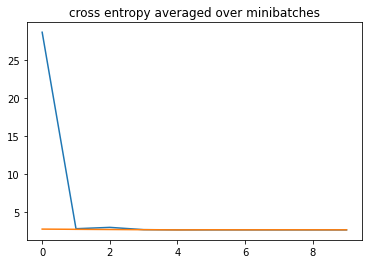

/home/antoine/.local/lib/python3.6/site-packages/ipykernel_launcher.py:91: UserWarning: Using a target size (torch.Size([1, 1980])) that is different to the input size (torch.Size([1997])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.


RuntimeError: The size of tensor a (1997) must match the size of tensor b (1980) at non-singleton dimension 1

In [71]:
batch_size = 1
input_dim = 4
hidden_dim = 64
num_classes = 17
lr = 0.05
n_epoch = 10

node_feature_dim = dataset.feature_dim

num_examples = len(dataset)
num_train = int(num_examples * 0.8)
num_val = int(num_examples * 0.1)

t = torch.arange(num_train)
idx = torch.randperm(t.nelement())
t = t.view(-1)[idx].view(t.size())
train_sampler = SubsetRandomSampler(t)

t = torch.arange(num_train, num_train+num_val)
idx = torch.randperm(t.nelement())
t = t.view(-1)[idx].view(t.size())
val_sampler = SubsetRandomSampler(t)

t = torch.arange(num_train+num_val, num_examples)
idx = torch.randperm(t.nelement())
t = t.view(-1)[idx].view(t.size())
test_sampler = SubsetRandomSampler(t)

train_dataloader = GraphDataLoader(
    dataset, sampler=train_sampler,batch_size=batch_size, drop_last=False, shuffle=False,
)
val_dataloader = GraphDataLoader(
    dataset, sampler=val_sampler, batch_size=batch_size, drop_last=False, shuffle=False,
)
test_dataloader = GraphDataLoader(
    dataset, sampler=test_sampler, batch_size=batch_size, drop_last=False, shuffle=False,
)

model = GCN_model_2(node_feature_dim, hidden_dim, num_classes)
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

early_stopping = EarlyStopping(tolerance=5, min_delta=10)

epoch_losses = []; val_losses = []
for epoch in range(n_epoch):
    epoch_loss = 0
    for iter, (batched_graph, labels) in enumerate(train_dataloader):
        
        pred = model(batched_graph, batched_graph.ndata["feat"].float())
        
        loss = F.cross_entropy(pred, torch.squeeze(labels))
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        epoch_loss += loss.detach().item()
    epoch_loss /= (iter + 1)
    epoch_losses.append(epoch_loss)
    
    val_loss = 0
    with torch.no_grad():
        for iter, (batched_graph, labels) in enumerate(val_dataloader):
            pred = model(batched_graph, batched_graph.ndata["feat"].float())
            loss = F.cross_entropy(pred, torch.squeeze(labels))
            val_loss += loss.detach().item()
        val_loss /= (iter + 1)
    val_losses.append(val_loss)
    
    early_stopping(epoch_loss, val_loss)
    if early_stopping.early_stop:
        print("We are at epoch:", epoch)
        break
    print(str(epoch)+': '+str(epoch_loss)+': '+str(val_loss))

plt.title('cross entropy averaged over minibatches')
plt.plot(epoch_losses, label='Train')
plt.plot(val_losses, label='Test')
plt.show()

num_correct = 0
num_tests = 0

pred_batch = []; id_batch = []
for batched_graph, labels in test_dataloader:
    graphs = dgl.unbatch(batched_graph)

    for i in range(len(graphs)):
        id_batch += [int(graphs[i].ndata["graph_id"][0].numpy())]



    mse = F.mse_loss(pred.argmax(1), labels)


print("Mean Square Error:", mse)

In [74]:
pred_batch = []; id_batch = []
for batched_graph, labels in test_dataloader:
    
    pred = model(batched_graph, batched_graph.ndata["feat"].float())

    # Convertir les prédictions et les étiquettes en tensors de type float
    predictions = pred.argmax(1).float()
    labels = torch.squeeze(labels).float()


    mse = F.mse_loss(predictions, labels)


print("Mean Square Error:", mse)

Mean Square Error: tensor(53.7833)


In [79]:
print(pred[0])

tensor([0.0000, 1.1295, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 1.1363, 1.5547, 1.6436, 0.0000, 0.0000, 0.0000, 0.0000],
       grad_fn=<SelectBackward0>)


In [80]:
print(pred.argmax(1)[0])

tensor(12)


In [76]:
print(predictions)
print(labels)

tensor([12., 11., 12.,  ...,  0.,  0.,  0.])
tensor([ 9., 12., 12.,  ...,  9., 11., 13.])


Idée:

- Ajouter que certaines parties de network metrics

- faire un one_hot encoding de l'heure 

- Regarder si on peut pas diminuer une classe (même si c'est pas du tout le plus urgent)

- Calculer une mean square error bien

- Changer complètement de modèle (rajouter des couches ou couches linéaires)

- Faire en sorte de pouvoir faire des batch_size